# **INTRO :**


> **Fraud detection is an important application of machine learning in the financial services sector. This solution will help Xente provide improved and safer service to its customers.The objective of this competition is to create a machine learning model to detect fraudulent transactions.**



# **Setup**



### 1. **Libraries**




In [3]:
'''Importing necessary libraries'''
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, f1_score

In [4]:
import warnings
warnings.simplefilter('ignore')



### 2.   **Get Data From Drive**


In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#importing the data
#path = "/content/drive/My Drive/Alliance4AI-Hackathons"
train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("/content/sample_submission.csv")

In [7]:
dfv = pd.read_csv('/content/Xente_Variable_Definitions.csv')
dfv

,Column Name,Definition
0,TransactionId,Unique �transaction identifier on platform
1,BatchId,Unique number assigned to a batch of transacti...
2,AccountId,Unique number identifying the customer on plat...
3,SubscriptionId,Unique number identifying the customer subscri...
4,CustomerId,Unique identifier attached to Account
5,CurrencyCode,Country currency
6,CountryCode,Numerical geographical code of country
7,ProviderId,Source provider of Item �bought.
8,ProductId,Item name being bought.
9,ProductCategory,ProductIds are organized into these broader pr...


# **Data Exploration**

In [8]:
#viewing a sample of the training data
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [9]:
train['ProductCategory'].value_counts()

financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
ticket                  216
movies                  175
transport                25
other                     2
Name: ProductCategory, dtype: int64

In [10]:
train['PricingStrategy'].value_counts()

2    79848
4    13562
1     1867
0      385
Name: PricingStrategy, dtype: int64

In [11]:
train['CountryCode'].value_counts()

256    95662
Name: CountryCode, dtype: int64

In [12]:
test['CountryCode'].value_counts()

256    45019
Name: CountryCode, dtype: int64

In [13]:
#cette colonne n'a pas d'utilité 
train = train.drop(['CountryCode'],axis=1)
test = test.drop(['CountryCode'],axis=1)

In [14]:
train['CurrencyCode'].value_counts()

UGX    95662
Name: CurrencyCode, dtype: int64

In [15]:
test['CurrencyCode'].value_counts()

UGX    45019
Name: CurrencyCode, dtype: int64

In [16]:
# de méme: colonne sans utilité
train = train.drop(['CurrencyCode'],axis=1)
test = test.drop(['CurrencyCode'],axis=1)

In [17]:
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2


In [18]:
#checking the shape of the train and test datasets
tr = train.shape
te = test.shape
print("train_set_shape is: {} and test_set_shape is: {}".format(tr,te))

train_set_shape is: (95662, 14) and test_set_shape is: (45019, 13)


In [19]:
#train set info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   ProviderId            95662 non-null  object 
 6   ProductId             95662 non-null  object 
 7   ProductCategory       95662 non-null  object 
 8   ChannelId             95662 non-null  object 
 9   Amount                95662 non-null  float64
 10  Value                 95662 non-null  int64  
 11  TransactionStartTime  95662 non-null  object 
 12  PricingStrategy       95662 non-null  int64  
 13  FraudResult           95662 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 10.2+ MB


In [20]:
train['FraudResult'].value_counts()  # Imbalanced data :)

0    95469
1      193
Name: FraudResult, dtype: int64

Text(0.5, 1.0, 'Fraudulent VS Non-Fraudulent')

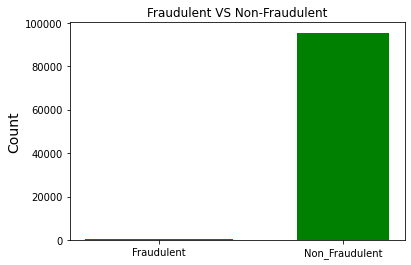

In [21]:
#Visualising Fraudulent and non-fraudulent cases
plt.bar("Fraudulent", train["FraudResult"].value_counts()[1], color="red")
plt.bar("Non_Fraudulent", train["FraudResult"].value_counts()[0], width=0.5, color="green")
plt.ylabel("Count", fontsize=14)
plt.title("Fraudulent VS Non-Fraudulent")

In [22]:
train.describe()

,Amount,Value,PricingStrategy,FraudResult
count,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,6.717846e+03,9.900584e+03,2.255974,0.002018
std,1.233068e+05,1.231221e+05,0.732924,0.044872
min,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,2.800000e+03,5.000000e+03,2.000000,0.000000
max,9.880000e+06,9.880000e+06,4.000000,1.000000


# **Feature-Engineering**

In [23]:
#label encoding columns
columns_to_Encode = ["BatchId",'AccountId','SubscriptionId','CustomerId',
                     'ProviderId','ProductId','ProductCategory','ChannelId',]
le = LabelEncoder()
for each in columns_to_Encode:
    train[each] = le.fit_transform(train[each])

for column in columns_to_Encode:
  test[column] = le.fit_transform(test[column])

In [24]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,46980,2490,3535,2584,5,1,0,2,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,31755,3219,2366,2584,3,19,2,1,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,60272,2713,996,2806,5,0,0,2,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,1797,3351,974,3733,0,11,8,2,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,48941,3219,2366,3733,3,19,2,1,-644.0,644,2018-11-15T03:34:21Z,2,0


In [25]:
#Extracting time and day from the TransactionStartTime column to create new features
train['hour'] = pd.to_datetime(train.TransactionStartTime).dt.hour
train['minute'] = pd.to_datetime(train.TransactionStartTime).dt.minute
train['day'] = pd.to_datetime(train.TransactionStartTime).dt.dayofweek

test['hour'] = pd.to_datetime(test.TransactionStartTime).dt.hour
test['minute'] = pd.to_datetime(test.TransactionStartTime).dt.minute
test['day'] = pd.to_datetime(test.TransactionStartTime).dt.dayofweek

In [26]:
# dropping the transaction starttime column
train = train.drop(["TransactionStartTime"], axis=1)
test = test.drop(["TransactionStartTime"], axis=1)

In [27]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,hour,minute,day
0,TransactionId_76871,46980,2490,3535,2584,5,1,0,2,1000.0,1000,2,0,2,18,3
1,TransactionId_73770,31755,3219,2366,2584,3,19,2,1,-20.0,20,2,0,2,19,3
2,TransactionId_26203,60272,2713,996,2806,5,0,0,2,500.0,500,2,0,2,44,3
3,TransactionId_380,1797,3351,974,3733,0,11,8,2,20000.0,21800,2,0,3,32,3
4,TransactionId_28195,48941,3219,2366,3733,3,19,2,1,-644.0,644,2,0,3,34,3


In [28]:
#corriger le probléme d'oversampling

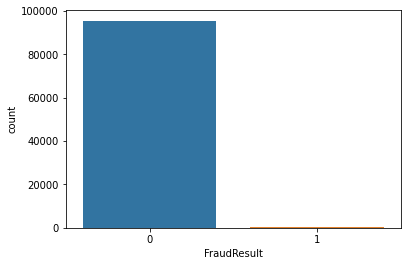

In [29]:
# visualize category class
sns.countplot(x='FraudResult', data=train)

In [30]:
from imblearn.over_sampling import SMOTE

count_class_0, count_class_1 = train.FraudResult.value_counts()

# divide by class
train_class_0 = train[train['FraudResult'] == 0]
train_class_1 = train[train['FraudResult'] == 1]

Random over-sampling:
1    95469
0    95469
Name: FraudResult, dtype: int64


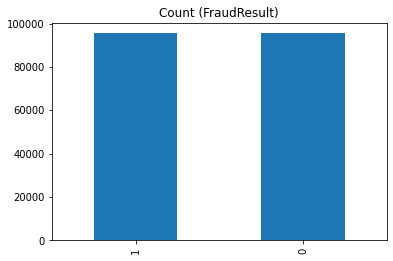

In [31]:
train_class_1_over = train_class_1.sample(count_class_0, replace=True)
train_test_over = pd.concat([train_class_0, train_class_1_over], axis=0)

print('Random over-sampling:')
print(train_test_over.FraudResult.value_counts())

train_test_over.FraudResult.value_counts().plot(kind='bar', title='Count (FraudResult)');

In [32]:
train1 = train_test_over 

In [33]:
train1.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,hour,minute,day
0,TransactionId_76871,46980,2490,3535,2584,5,1,0,2,1000.0,1000,2,0,2,18,3
1,TransactionId_73770,31755,3219,2366,2584,3,19,2,1,-20.0,20,2,0,2,19,3
2,TransactionId_26203,60272,2713,996,2806,5,0,0,2,500.0,500,2,0,2,44,3
3,TransactionId_380,1797,3351,974,3733,0,11,8,2,20000.0,21800,2,0,3,32,3
4,TransactionId_28195,48941,3219,2366,3733,3,19,2,1,-644.0,644,2,0,3,34,3


In [34]:
# dropping non-predictor feature columns and the target(train-set only)
target = train1["FraudResult"]
train1 = train1.drop(["FraudResult","TransactionId"], axis=1)

# we need it for the Submission Creation
test_id = test["TransactionId"]
test = test.drop(["TransactionId"], axis=1)

In [35]:
columns = train1.columns
X = train1
y = target

X_train, X_val, y_train, y_val = train_test_split(X,y,stratify=y, test_size=0.25,
                                                  random_state=17)

# **Modeling**

In [63]:
import lightgbm as lgb
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [64]:
%%time

weight = 10
param = { 'num_leaves': 80,
    'boost': 'gbdt',
    'learning_rate': 0.03,
    'metric':'binary_logloss',
    'scale_pos_weight': round(weight, 1),
    
 
    
    'objective': 'binary',
    'random_state': 42,
    
}

lgb_model = lgb.train(param, trn_data, 5000, valid_sets = [trn_data, val_data], 
                      verbose_eval=200, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's binary_logloss: 0.00224508	valid_1's binary_logloss: 0.00259173
[400]	training's binary_logloss: 2.62159e-05	valid_1's binary_logloss: 0.000696211
[600]	training's binary_logloss: 2.76083e-07	valid_1's binary_logloss: 0.000740144
Early stopping, best iteration is:
[433]	training's binary_logloss: 1.19082e-05	valid_1's binary_logloss: 0.000673534
CPU times: user 37.6 s, sys: 245 ms, total: 37.8 s
Wall time: 19.5 s


In [65]:
# Validation - Performance
pred = lgb_model.predict(X_val,num_iteration=lgb_model.best_iteration)



> Our Evaluation Metric is [F1-Score](https://medium.com/@kennymiyasato/classification-report-precision-recall-f1-score-accuracy-16a245a437a5) 



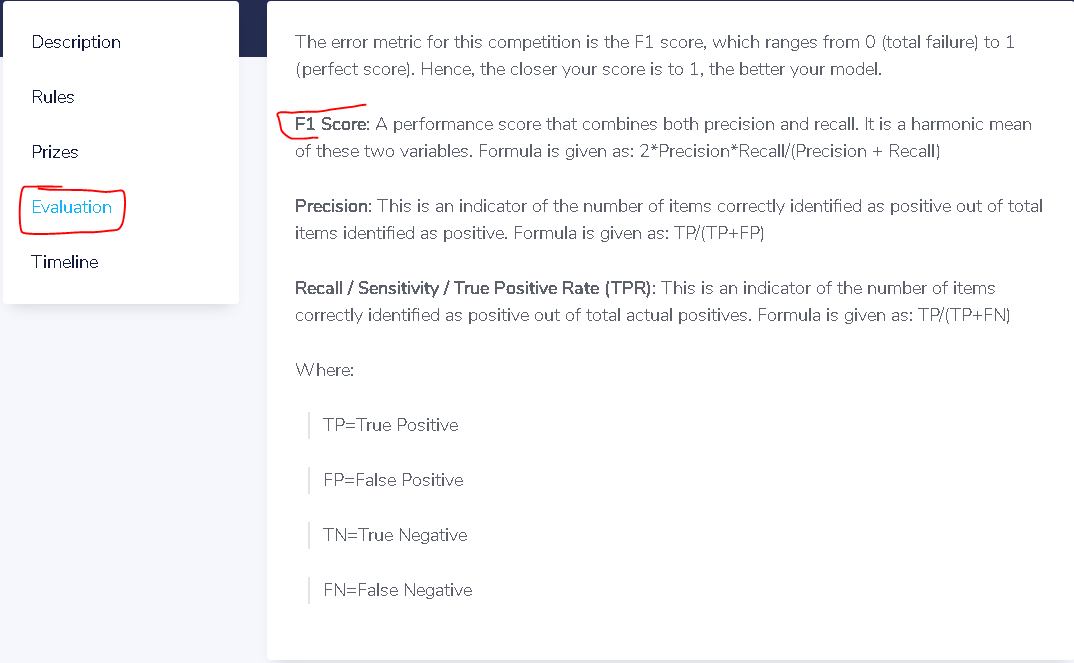

In [66]:
threshold = 0.5
pred  = (pred >=threshold)*1
print('F1 Score : ', f1_score(y_val, pred),'mean is :' ,np.mean(pred))

F1 Score :  0.9998952682180934 mean is : 0.500115219440662


In [67]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23867
           1       1.00      1.00      1.00     23868

    accuracy                           1.00     47735
   macro avg       1.00      1.00      1.00     47735
weighted avg       1.00      1.00      1.00     47735



# **Create-Submission**

In [68]:
test_pred = lgb_model.predict(test.values,num_iteration  = lgb_model.best_iteration)

In [69]:
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = (test_pred >= threshold)*1
submission.target.value_counts() , np.mean(submission.target)

(0    44932
 1       87
 Name: target, dtype: int64, 0.0019325173815500122)

In [70]:
submission.head()

,CID X LOC_NUM X VENDOR,target
0,TransactionId_50600,0
1,TransactionId_95109,0
2,TransactionId_47357,0
3,TransactionId_28185,0
4,TransactionId_22140,0


In [71]:
submission.shape

(45019, 2)

In [ ]:
submission.to_csv('LGBM_thresh_{}.csv'.format(threshold), index=False)

In [ ]:
#modéle 2 Random Forest Classifier






In [57]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=100,random_state=17)

In [58]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [59]:
y_pred = clf.predict(X_val)

In [60]:
threshold = 0.5
y_pred  = (y_pred >=threshold)*1
print('F1 Score : ', f1_score(y_val, y_pred),'mean is :' ,np.mean(y_pred))

F1 Score :  0.9999162128194387 mean is : 0.5000942704514507


In [ ]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23867
           1       1.00      1.00      1.00     23868

    accuracy                           1.00     47735
   macro avg       1.00      1.00      1.00     47735
weighted avg       1.00      1.00      1.00     47735



In [ ]:
test_pred1 = clf.predict(test.values)

In [ ]:
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = (test_pred1 >= threshold)*1
submission.target.value_counts() , np.mean(submission.target)

(0    44951
 1       68
 Name: target, dtype: int64, 0.0015104733556942625)

In [ ]:
submission.to_csv('Random_Forest.csv', index=False)

In [ ]:
# setup parameters for xgboost
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'multi:softmax'
param["eval_metric"] = "error"
param['eta'] = 0.4
param['max_depth'] = 3
param['min_child_weight']=2
param['subsample']= 1
param['colsample_bytree']=1
param['base_score'] = 0.6
param['learning_rate'] = 0.1
param['num_class'] = 2

In [ ]:
xcl.set_params(**param)

XGBClassifier(base_score=0.6, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.4,
              eval_metric='error', gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, num_class=2, objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=1, subsample=1, verbosity=1)

In [ ]:
xcl.fit(X_train, y_train)
pred3 = xcl.predict(X_val)
print(f1_score(y_val,pred3))
print(np.mean(pred3))

0.999539344193643
0.5004713522572536


In [ ]:
# essayer d'améliorer le modéle de RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=100,random_state=17)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
threshold = 0.5
y_pred  = (y_pred >=threshold)*1
print('F1 Score : ', f1_score(y_val, y_pred),'mean is :' ,np.mean(y_pred))

F1 Score :  0.9999371582982467 mean is : 0.5000733214622395


In [ ]:
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23867
           1       1.00      1.00      1.00     23868

    accuracy                           1.00     47735
   macro avg       1.00      1.00      1.00     47735
weighted avg       1.00      1.00      1.00     47735



In [ ]:
test_pred1 = clf.predict(test.values)
submission = pd.DataFrame()
submission['CID X LOC_NUM X VENDOR'] = test_id
submission['target'] = (test_pred1 >= threshold)*1
submission.target.value_counts() , np.mean(submission.target)
submission.to_csv('Random_Forest_V2.csv', index=False)

In [44]:
#travail du 2éme jour

In [45]:
#utiliser d'autres modéles

In [46]:
#essayer de mieux utiliser les données
X2 = X
y2 = y
X2.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,hour,minute,day
0,46980,2490,3535,2584,5,1,0,2,1000.0,1000,2,2,18,3
1,31755,3219,2366,2584,3,19,2,1,-20.0,20,2,2,19,3
2,60272,2713,996,2806,5,0,0,2,500.0,500,2,2,44,3
3,1797,3351,974,3733,0,11,8,2,20000.0,21800,2,3,32,3
4,48941,3219,2366,3733,3,19,2,1,-644.0,644,2,3,34,3


In [47]:
X2.shape

(190938, 14)

In [48]:
X2['Time'] = X2.minute + X2.hour * 60 + X2.day * 1440

In [49]:
X2.drop(['minute','hour','day'],axis=1,inplace=True)

In [50]:
X2.Time.max()

10076

In [51]:
X2.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,Time
0,46980,2490,3535,2584,5,1,0,2,1000.0,1000,2,4458
1,31755,3219,2366,2584,3,19,2,1,-20.0,20,2,4459
2,60272,2713,996,2806,5,0,0,2,500.0,500,2,4484
3,1797,3351,974,3733,0,11,8,2,20000.0,21800,2,4532
4,48941,3219,2366,3733,3,19,2,1,-644.0,644,2,4534


In [52]:
X2['Amount'] = X2['Amount'].astype('int64')

In [53]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190938 entries, 0 to 65321
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   BatchId          190938 non-null  int64
 1   AccountId        190938 non-null  int64
 2   SubscriptionId   190938 non-null  int64
 3   CustomerId       190938 non-null  int64
 4   ProviderId       190938 non-null  int64
 5   ProductId        190938 non-null  int64
 6   ProductCategory  190938 non-null  int64
 7   ChannelId        190938 non-null  int64
 8   Amount           190938 non-null  int64
 9   Value            190938 non-null  int64
 10  PricingStrategy  190938 non-null  int64
 11  Time             190938 non-null  int64
dtypes: int64(12)
memory usage: 18.9 MB


In [61]:
X2['diff'] = abs(X2.Value) - abs(X2.Amount)

In [62]:
X2.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,Time,diff
0,46980,2490,3535,2584,5,1,0,2,1000,1000,2,4458,0
1,31755,3219,2366,2584,3,19,2,1,-20,20,2,4459,0
2,60272,2713,996,2806,5,0,0,2,500,500,2,4484,0
3,1797,3351,974,3733,0,11,8,2,20000,21800,2,4532,1800
4,48941,3219,2366,3733,3,19,2,1,-644,644,2,4534,0


In [57]:
X2.PricingStrategy.value_counts()

2    148355
4     18897
0     18275
1      5411
Name: PricingStrategy, dtype: int64

In [77]:
X2['Amount'][1]

-20

In [78]:
diff2 =np.ones((X2.shape[0],1))
diff2 = [X2.Amount == X2.Value]


In [84]:
X2['Amount'][1] == X2['Value'][1]

False

In [86]:
X2.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,Time,diff,diff2
0,46980,2490,3535,2584,5,1,0,2,1000,1000,2,4458,0,0
1,31755,3219,2366,2584,3,19,2,1,-20,20,2,4459,0,0
2,60272,2713,996,2806,5,0,0,2,500,500,2,4484,0,0
3,1797,3351,974,3733,0,11,8,2,20000,21800,2,4532,1800,1800
4,48941,3219,2366,3733,3,19,2,1,-644,644,2,4534,0,0


In [94]:
X2.drop('diff2',axis=1,inplace=True)

In [95]:
X2['diff2'] = X2.Value - X2.Amount

In [96]:
X2.head()

,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,Time,diff,diff2
0,46980,2490,3535,2584,5,1,0,2,1000,1000,2,4458,0,0
1,31755,3219,2366,2584,3,19,2,1,-20,20,2,4459,0,40
2,60272,2713,996,2806,5,0,0,2,500,500,2,4484,0,0
3,1797,3351,974,3733,0,11,8,2,20000,21800,2,4532,1800,1800
4,48941,3219,2366,3733,3,19,2,1,-644,644,2,4534,0,1288


In [97]:
X2.ProviderId.value_counts()

4    45947
3    40611
5    35657
2    34879
0    33826
1       18
Name: ProviderId, dtype: int64

In [98]:
X2.ChannelId.value_counts()

2    147843
1     39563
0      2484
3      1048
Name: ChannelId, dtype: int64

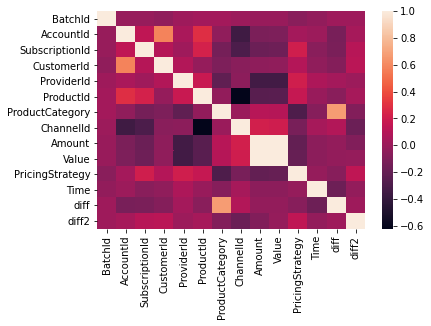

In [108]:
# Calculate and plot
mat = X2.corr()
sns.heatmap(mat)

In [109]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
# Initialize a stratified split of our dataset for the validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier with the default parameters 
rfc = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=100,random_state=17)

# Train it on the training set
results = cross_val_score(rfc, X2, y2, cv=skf)

# Evaluate the accuracy on the test set
print("CV accuracy score: {:.2f}%".format(results.mean() * 100))

CV accuracy score: 99.99%


In [99]:
X_train2 , X_val2 , y_train2, y_val2 = train_test_split(X2,y2,test_size = 0.2,random_state=17)

In [100]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=100,random_state=17)

In [101]:
clf.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [102]:
y_pred2 = clf.predict(X_val2)
threshold = 0.5
y_pred2  = (y_pred2 >=threshold)*1
print('F1 Score : ', f1_score(y_val2, y_pred2),'mean is :' ,np.mean(y_pred2))
from sklearn.metrics import f1_score, classification_report
print(classification_report(y_val2, y_pred2))

F1 Score :  0.9998951177303477 mean is : 0.49939771656017595
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19121
           1       1.00      1.00      1.00     19067

    accuracy                           1.00     38188
   macro avg       1.00      1.00      1.00     38188
weighted avg       1.00      1.00      1.00     38188



In [110]:
#modéle 

In [117]:
clf = RandomForestClassifier(n_estimators=500,criterion='entropy',max_depth=100,random_state=17,max_features=10,min_samples_leaf=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_val)
threshold = 0.5
y_pred  = (y_pred >=threshold)*1
print('F1 Score : ', f1_score(y_val, y_pred),'mean is :' ,np.mean(y_pred))


F1 Score :  0.9999162128194387 mean is : 0.5000942704514507
